In [1]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches


from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga

import scbeta_scrnaseq.figure_vis as fv

from sklearn.neighbors import RadiusNeighborsRegressor, KernelDensity


from scbeta_scrnaseq.figure_vis import core_colors
fv.setup_matplotlib_params()
mm_per_inch = 25.4

Populating the interactive namespace from numpy and matplotlib


In [2]:
def save_df(obj, filename):
    np.savez_compressed(filename, data=obj.values, index=obj.index.values, columns=obj.columns.values)
    
def load_df(filename):
    with np.load(filename) as f:
        obj = pd.DataFrame(**f)
    return obj

In [3]:
matplotlib.font_manager._rebuild()

In [4]:
import glob
pb_tpm = {}
for pbf in glob.glob('../*/data/complete_processing/*.pseudobulk_tpm.df.npz'):
    key = os.path.basename(pbf)[:-(len('.pseudobulk_tpm.df.npz'))]
    pb_tpm[key] = utils.load_df(pbf)
    
pb_expr = {}
for pbf in glob.glob('../*/data/complete_processing/*.expr_frac.df.npz'):
    key = os.path.basename(pbf)[:-(len('.expr_frac.df.npz'))]
    pb_expr[key] = utils.load_df(pbf)

In [5]:
cluster_order = [
    ('stage6.labels', 'scbeta'),
    ('stage6.labels', 'ec'),
    ('stage6.labels', 'ph'),
    ('stage6.labels', 'exo'),
    ('human_islets.labels', 'beta'),
    ('human_islets.labels', 'alpha'),
    ('human_islets.labels', 'gamma'),
    ('human_islets.labels', 'delta'),
][::-1]

def combine_rows(dfs, rows, na=0):
    new_df = OrderedDict({})
    for inrow in rows:
        if len(inrow) == 2:
            df, row = inrow
            label = f"{df} {row}"
        elif len(inrow) == 3:
            df, row, label = inrow
            
        new_df[label] = dfs[df].loc[row]
    new_df = pd.DataFrame(new_df).fillna(na).T
    return new_df

cluster_tpm = combine_rows(pb_tpm, cluster_order)
cluster_expr = combine_rows(pb_expr, cluster_order)

2019-04-10 16:13:45,323 WARNING: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2019-04-10 16:13:45,330 WARNING: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


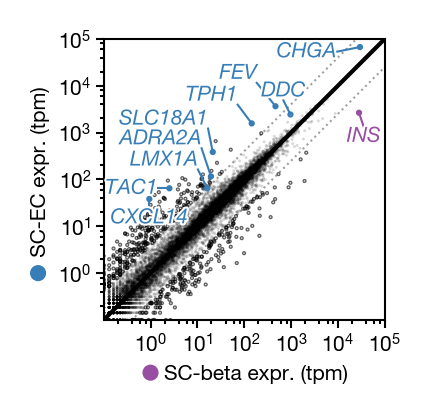

In [9]:
import matplotlib.patheffects as PathEffects
emphasis_color = core_colors.blue
fig = plt.figure(figsize=(34/mm_per_inch,34/mm_per_inch), dpi=300)

ax = fig.add_axes([0.25, 0.25, 0.70, 0.70],
                  xscale='log', yscale='log',
#                   title='Comparison of SC-EC and SC-beta cells'
                  frameon=True)
# de_genes = (log_fc.abs() > permuted_max_fc) & (log_fc.abs() > np.log2(fc_thr))

x = cluster_tpm.loc['stage6.labels scbeta'] + 0.1
y = cluster_tpm.loc['stage6.labels ec'] + 0.1

log_fc = np.log2(y) - np.log2(x)
fc_thr = 4
de_genes = (log_fc.abs() > np.log2(fc_thr))


ax.scatter(x, y, c='k', s=0.5, edgecolor='none', 
           alpha=0.15,
          rasterized=True)

ax.scatter(x[de_genes], y[de_genes], c='none', s=0.5, edgecolor='k', 
           alpha=0.6, linewidths = 0.3)

#
# Drawing lines and setting up axis
#


plot_lims = np.array([0.1, 10**5])
ax.plot(plot_lims, plot_lims, linestyle='-',linewidth=1.0, color='k', zorder=-10)


for fc in [fc_thr, 1./fc_thr]:
    ax.plot(plot_lims, fc*plot_lims,
            linestyle='dotted', linewidth=0.5, color='#a0a0a0', zorder=-10)



ax.set_xticks(10**np.arange(0, 6, 1))
ax.set_yticks(10**np.arange(0, 6, 1))

ax.tick_params(axis='both', which='major', pad=1)
ax.set_xlabel('    SC-beta expr. (tpm)', fontsize=5, labelpad=2)
ax.set_ylabel('   SC-EC expr. (tpm)', fontsize=5, labelpad=2)


ax.scatter([10**-2.4], [10**0], c=core_colors.blue, edgecolor='none', s=fv.tsne_legend_ms, clip_on=False)
ax.scatter([10**0], [10**-2.125], c=core_colors.purple, edgecolor='none', s=fv.tsne_legend_ms, clip_on=False)



ax.set_xlim(plot_lims)
ax.set_ylim(plot_lims)

gene_label_fontsize = 6
# GOOD highlight genes

ec_label_genes = [
    ('TAC1', (0.05,0.0), 'right', 'center'),
    ('TPH1', (0,0.3), 'right', 'bottom'),
    ('SLC18A1', (0.2,0.4), 'right', 'bottom'),
    ('DDC', (0.15,0.2), 'center', 'bottom'),
    ('LMX1A', (0.1,0.3), 'right', 'bottom'),
    ('FEV', (-0.1,0.4), 'right', 'bottom'),
    ('CHGA', (-0.2,-0.1), 'right', 'center'),
    ('CXCL14', (0.3,-0.1), 'center', 'top'),
    ('ADRA2A', (0.1,0.5), 'right', 'bottom'),
]

scb_label_genes = [
    ('INS', (0.4,-0.2), 'center', 'top'),
#     ('PDX1', (0.4,-0.2), 'center', 'top'),
#     ('ISL1', (0.5,-0.2), 'left', 'top'),
]

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


# for _x, _y, _c in [(0.00264, 1, core_colors.blue), (0.8, 0.0058, core_colors.purple)]:
#     ax.scatter(_x, _y,  c=_c, s=10, clip_on=False)


for col, label_genes in [(core_colors.purple, scb_label_genes), (core_colors.blue, ec_label_genes)]:
    
    ax.scatter(x[[g for g,_,_,_ in label_genes]], y[[g for g,_,_,_ in label_genes]], c='none',
           s=1, edgecolor=col,
           alpha=1.0, linewidths = 0.5)
    

    for g,g_offset,ha,va in label_genes:

        x_offset, y_offset = np.array(g_offset)
        x_offset -= 0.3
        if va == 'top':
            y_offset += -0.1
        if va == 'bottom':
            y_offset += 0.1

        txt = ax.text(x[g] * 10**(x_offset), y[g] * 10** y_offset, g,
                      fontsize=5, color=col, style='italic',
                      va=va, ha=ha)
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])


        ax.plot([x[g], x[g] * 10**(x_offset)], [y[g],y[g] * 10** y_offset], linewidth=0.5, color=col)

    
fig.savefig('../../figures/components/main_figure3/SCbeta_vs_SCEC.pdf', dpi=600, transparent=True)


In [10]:
g_grp = [[
    'TPH1', 'TPH2', 'DDC', 'SLC18A1', 'SLC18A2', 'NEUROG3', 'NKX2-2', 'LMX1A', 'FEV', 'CDX2', 'ADRA2A', 'NEUROD4',
    'TAC1', 'CXCL14', "MME", 'GPC4',  'ITPR3', 'SOX2', 'FATE1', 'GPRC5A', 'COL5A2', 'SYT6', 'ASCL1',
],[]]


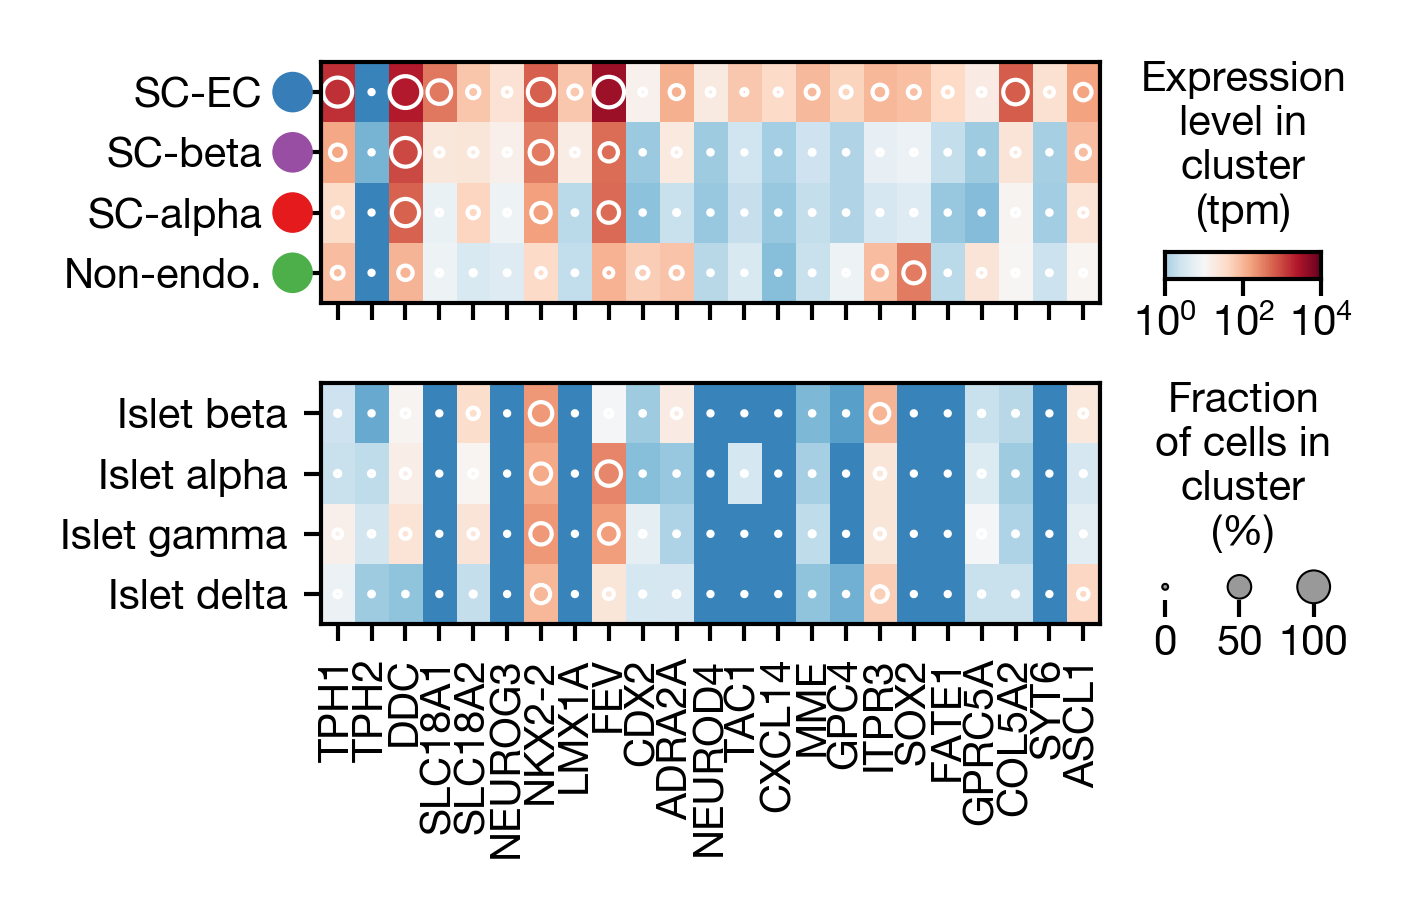

In [8]:
fig = plt.figure(figsize=((89-34)/mm_per_inch, (34/mm_per_inch) * 1.10 ), dpi=600)

norm_tpm = np.log10(cluster_tpm.copy() + 0.1)
vmin, vmax = (-2, 4)
cvmin, cvmax = (0, 4)


cmap = "RdBu_r"


co1 = ['stage6.labels ec', 'stage6.labels scbeta', 'stage6.labels ph',
       'stage6.labels exo', ][::-1]
co2 = ['human_islets.labels beta', 'human_islets.labels alpha', 'human_islets.labels gamma',
       'human_islets.labels delta'][::-1]

ax1_pos = [0.20, 0.1/1.1 + 0.65/1.10, 0.60, 0.30/1.10]

ax2_pos = [0.20, 0.1/1.1 + 0.25/1.10, 0.60, 0.30/1.10]

for ci,(co, ax_pos, samp) in enumerate([(co1, ax1_pos, 'stage6'), (co2, ax2_pos, 'human_islets')]):
    _tpm = norm_tpm.loc[co][sum(g_grp)].values
    _frac = cluster_expr.loc[co][sum(g_grp)].values

    _y, _x = np.mgrid[:_tpm.shape[0], :_tpm.shape[1]]
    _x = _x.ravel()
    _y = _y.ravel()

    
    ax = fig.add_axes(ax_pos, xscale='linear', yscale='linear',
                xlabel='', ylabel='', frameon=True)
    
#     ax = fig.add_subplot(gs[ci], )
    ax.set_axisbelow(True)

    ax.imshow(_tpm, aspect='auto',  cmap='RdBu_r', vmin=vmin, vmax=vmax)
    
    frac_scaling_factor = 15
    imax = ax.scatter(_x, _y, s=0.25 + _frac.ravel()*frac_scaling_factor, c=_tpm.ravel(),
               linewidth=0.5, edgecolor='w',
    #                   edgecolor=core_colors.grey,
               cmap=cmap, vmin=vmin, vmax=vmax, 
              )

    # Draw fancy y tick labels
    ax.set_yticks(range(_tpm.shape[0]))
    tick_labels = []
    label_params = fv.dataset_label_params(samp)
    tick_mark_colors = []
    for stg_cl in co:
        stg, cl = stg_cl.split(' ')
        tick_labels.append(f"{label_params[cl]['short_label']}")
        tick_mark_colors.append(label_params[cl]['color'])
        
    labelpad = 5 if samp=='stage6' else 2
    ax.set_yticklabels(tick_labels, fontsize=5)
    ax.tick_params(which='both', pad=labelpad)
    

    if samp == 'stage6':
        ax.scatter(np.ones(4)*-1.33, range(4), s=fv.heatmap_legend_ms, c=tick_mark_colors, clip_on=False)

    # Fix plot limits
    ax.set_xticks(range(len(sum(g_grp))))
    
    if samp == 'human_islets':
        ax.set_xticklabels(sum(g_grp), rotation=90, fontsize=5);
    else:
        ax.set_xticklabels([])
        
    ax.set_xlim([-0.50, len(sum(g_grp))-0.5])
    ax.set_ylim([-0.50, _tpm.shape[0]-0.5])
    
    


# fig.savefig('components/main_figure3/MainFigure3B.pdf', dpi=600)

###### Colorbar
# 
#

# colorbar_ax_position = [0.13, 0.19, 0.12, 0.03]
colorbar_ax_position = [0.85, 0.1/1.1 + 0.68/1.10, 0.12, 0.03]
colorbar_ax = fig.add_axes(colorbar_ax_position,
                xscale='linear', yscale='linear', yticks=[0.5],
                xlabel='', ylabel='', frameon=True, )

gradient = np.linspace(-cvmin, cvmax, 256)
gradient = np.vstack((gradient, gradient))
colorbar_ax.imshow(gradient, aspect='auto', extent=(-cvmin,cvmax,0,1), 
            cmap=imax.cmap, vmin=vmin, vmax=vmax)

# colorbar_ax.tick_params(axis='y', which='major', pad=2, width=0.5, zorder=-10, length=0)

xticks = np.linspace(cvmin, cvmax, 3).astype(int)
colorbar_ax.set_xticks([0, 2, 4])
colorbar_ax.set_xticklabels(['10$^0$','10$^2$', '10$^4$'], fontsize=5);

# colorbar_ax.set_yticklabels(['norm. tpm'], fontsize=5);
colorbar_ax.set_yticks([])
colorbar_ax.set_title('Expression\nlevel in\ncluster\n(tpm)', fontsize=5, y=0.2);

###### Expression % legend
# 
#

# size_ax_position = [0.13, 0.09, 0.12, 0.03]
size_ax_position = [0.85, 0.1/1.1 + 0.28/1.10, 0.12, 0.03]
size_ax = fig.add_axes(size_ax_position,
                xscale='linear', yscale='linear', yticks=[0], xticks=range(4),
                xlabel='', ylabel='', frameon=False, )


tick_sizes = 0.5 + np.linspace(0,1,3)*frac_scaling_factor
tick_labels = ['0', '50', '100']
xpos = np.linspace(0,1, len(tick_sizes))


size_ax.scatter(xpos, np.zeros_like(tick_sizes), s=tick_sizes,
                facecolor=core_colors.grey,
                edgecolor='k',linewidth=0.25, clip_on=False)
size_ax.set_xlim([0,1.05])
size_ax.set_xticks(xpos)
# size_ax.tick_params(axis='both', which='major', pad=2, width=0.5, zorder=-10, length=2)
size_ax.set_xticklabels(tick_labels, fontsize=5);

# size_ax.set_yticklabels(['Expressed (%)'], fontsize=5);

size_ax.set_yticks([])
size_ax.set_title('Fraction\nof cells in\ncluster\n(%)', fontsize=5, y=0.2);
size_ax.set_axisbelow(True)

fig.savefig('../../figures/components/main_figure3/SCEC_genes_heatmap.pdf', dpi=600, transparent=True)




In [11]:
limma_results = {}
for key in ['WT__8wks_25wks', '25wks__WT_HET', '25wks__WT_KO']:
    limma_results[key] = utils.load_df('/Users/averes/Projects/Melton/Notebooks/2018/04-2018/EED_KO_limma_results.%s.df.npz'%key)

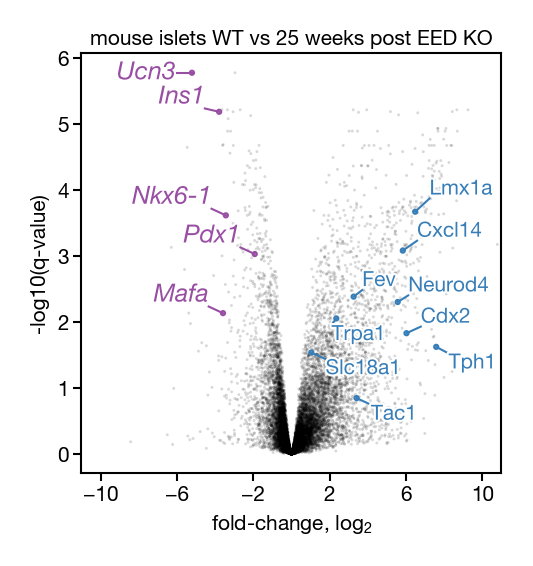

In [12]:
import matplotlib.patheffects as PathEffects
emphasis_color = 'red'
fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.add_axes([0.25, 0.16, 0.70, 0.70],
                  xscale='linear', yscale='linear',
                  frameon=True)
ax.set_xlabel(r'fold-change, log$_2$', fontsize=5, labelpad=2)
ax.set_ylabel('-log10(q-value)', fontsize=5, labelpad=2)
ax.set_title('mouse islets WT vs 25 weeks post EED KO', fontsize=5, pad=2)

# de_genes = (log_fc.abs() > permuted_max_fc) & (log_fc.abs() > np.log2(fc_thr))

coef = '25wks__WT_KO'
# coef = 'WT__8wks_25wks'
x = limma_results[coef]['logFC']
y = -np.log10(limma_results[coef]['adj.P.Val'].astype(float))

ax.scatter(x, y, c='k', s=0.5, edgecolor='none', 
           alpha=0.15, rasterized=True)


plot_lims = np.array([0.5, 10**5])
emphasis_color = core_colors.blue
ax.set_xlim([-11, 11])
ax.set_xticks([-10, -6, -2, 2, 6, 10])
gene_label_fontsize = 5
# GOOD highlight genes
label_genes = [
    ('Fev', (-0.3,0), 'left', 'bottom'),
    ('Lmx1a', (0,0.1), 'left', 'bottom'),
    ('Tph1', (-0.1,0), 'left', 'top'),
    ('Slc18a1', (0,0), 'left', 'top'),
    ('Trpa1', (-1,0), 'left', 'top'),
    ('Tac1', (0,0), 'left', 'top'),
    ('Neurod4', (-0.2,0), 'left', 'bottom'),
    ('Cdx2', (0,0),  'left', 'bottom'),
    ('Cxcl14', (0,.05), 'left', 'bottom'),
]
base_offset = np.array((1, -0.2))
ax.scatter(x[[g for g,_,_,_ in label_genes]], y[[g for g,_,_,_ in label_genes]], c='none',
           s=1, edgecolor=emphasis_color, 
           alpha=1.0, linewidths = 0.5)

for g,g_offset,ha,va in label_genes:
    
    x_offset, y_offset = np.array(g_offset)
    x_offset += 0.75
    if va == 'top':
        y_offset += -0.1
    if va == 'bottom':
        y_offset += 0.1
    
    txt = ax.text(x[g] + x_offset, y[g] + y_offset, g,
                  fontsize=5, color=emphasis_color,
                  va=va, ha=ha)
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])

    ax.plot([x[g], x[g] + x_offset], [y[g], y[g] + y_offset], linewidth=0.5, color=emphasis_color)

    
emphasis_color = core_colors.purple
gene_label_fontsize = 6
# GOOD highlight genes
label_genes = [
    ('Ucn3', (-0.1,0), 'right', 'center'),
    ('Pdx1', (0,0), 'right', 'bottom'),
    ('Mafa', (0,0), 'right', 'bottom'),
    ('Ins1', (0,-0.05), 'right', 'bottom'),
    ('Nkx6-1', (0,0), 'right', 'bottom'),
]

ax.scatter(x[[g for g,_,_,_ in label_genes]], y[[g for g,_,_,_ in label_genes]], c='none',
           s=1, edgecolor=emphasis_color, 
           alpha=1.0, linewidths = 0.5)

for g,g_offset,ha,va in label_genes:
    
    x_offset, y_offset = np.array(g_offset)
    x_offset += -0.75
    if va == 'top':
        y_offset += -0.1
    if va == 'bottom':
        y_offset += 0.1
    
    txt = ax.text(x[g] + x_offset, y[g] + y_offset, g,
                  fontsize=6, color=emphasis_color,  style='italic',
                  va=va, ha=ha)
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])

    ax.plot([x[g], x[g] + x_offset], [y[g], y[g] + y_offset], linewidth=0.5, color=emphasis_color)

    
fig.savefig('../../figures/components/extended_figure5/MainFigure3C.pdf', dpi=600, transparent=True)


In [14]:
nkx61_sort_data = pd.read_excel("../04_Misc/data/1-s2.0-S1873506118301119-mmc3.xlsx", skiprows=1, index_col=1)

In [15]:
nkx61_mean = nkx61_sort_data.baseMean.fillna(.0)
nkx61_logfc = nkx61_sort_data.log2FoldChange.fillna(.0)
nkx61_pdaj = nkx61_sort_data.padj.fillna(1.0)

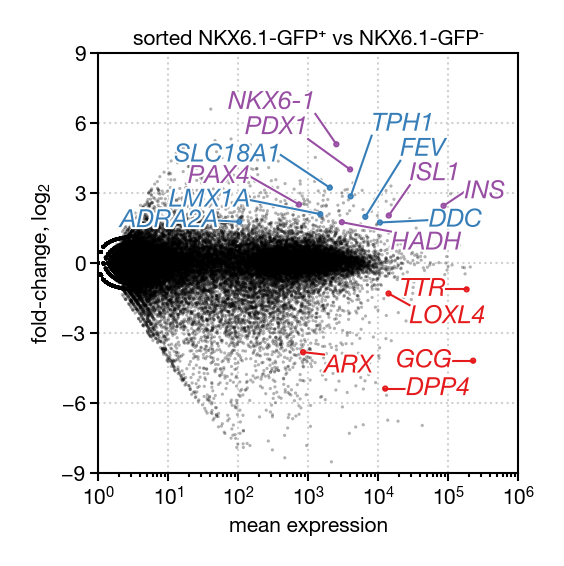

In [18]:
import matplotlib.patheffects as PathEffects
emphasis_color = core_colors.blue
fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.add_axes([0.25, 0.16, 0.70, 0.70],
                  xscale='log', yscale='linear',
#                   title='Comparison of SC-EC and SC-beta cells'
                  frameon=True)
ax.set_xlabel('mean expression', fontsize=5, labelpad=2)
ax.set_ylabel('fold-change, $log_2$', fontsize=5, labelpad=2)
ax.set_title('sorted NKX6.1-GFP⁺ vs NKX6.1-GFP⁻', fontsize=5, pad=2)


# de_genes = (log_fc.abs() > permuted_max_fc) & (log_fc.abs() > np.log2(fc_thr))

x = nkx61_mean + 1
y = nkx61_logfc


ax.scatter(x, y, c='k', s=0.6, edgecolor='none', 
           alpha=0.30,
          rasterized=True)



xlims = [1, 10**6]
ylims = [-9, 9]
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# ax.set_yticks([-8,-6,-4,-2,0,2,4,6,8])
ax.set_yticks([-9,-6,-3,0,3,6,9])

gene_label_fontsize = 5
# GOOD highlight genes

ec_label_genes = [
    ('FEV', (0.2,2.3), 'left', 'bottom'),
    ('LMX1A', (-0.7,0.6), 'right', 'center'),
    ('TPH1', (0.,2.5), 'left', 'bottom'),
    ('SLC18A1', (-0.4,1.4), 'right', 'center'),
    ('DDC', (0.4,.1), 'left', 'center'),
    ('ADRA2A', (0,.05), 'right', 'center',),
]

scb_label_genes = [
    ('PDX1', (-0.3,1.2), 'right', 'bottom'),
    ('ISL1', (0,1.2), 'left', 'bottom'),
    ('INS', (0,0.6), 'left', 'center'),
    ('HADH', (0.4,-0.3), 'left', 'top'),
    ('NKX6-1', (0,1.2), 'right', 'bottom'),
    ('PAX4', (-0.4,1.2), 'right', 'center'),
]

ph_label_genes = [
    ('GCG', (0.,0.), 'right', 'center'),
    ('ARX', (0,0), 'left', 'top'),
    ('DPP4', (0,0.), 'left', 'center'),
    ('TTR', (0,0.), 'right', 'center'),
    ('LOXL4', (0.,-0.4), 'left', 'top'),
#     ('NKX6-1', (0,1.2), 'right', 'bottom'),
#     ('PAX4', (-0.4,1.2), 'right', 'center'),
]

ax.grid(True)
ax.yaxis.grid(color='#d0d0d0', linestyle='dotted', linewidth=0.5)
ax.xaxis.grid(color='#d0d0d0', linestyle='dotted', linewidth=0.5)
ax.set_axisbelow(True)
    

for col, label_genes in [(core_colors.purple, scb_label_genes),
                         (core_colors.blue, ec_label_genes),
                         (core_colors.red, ph_label_genes)]:
    
    ax.scatter(x[[g for g,_,_,_ in label_genes]], y[[g for g,_,_,_ in label_genes]], c='none',
           s=1, edgecolor=col,
           alpha=1.0, linewidths = 0.5, zorder=20)
    

    for g,g_offset,ha,va in label_genes:

        x_offset, y_offset = np.array(g_offset)
        if ha =='right':
            x_offset -= 0.3
        if ha == 'left':
            x_offset += 0.3
        if va == 'top':
            y_offset += -0.1
        if va == 'bottom':
            y_offset += 0.1
            
            
        xoff = 10**(np.log10(x[g]) + x_offset)
        yoff = y[g] + y_offset
        
        txt = ax.text(xoff, yoff, g,
                      fontsize=6, color=col,  style='italic',
                      va=va, ha=ha, zorder=15)
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])


        line = ax.plot([x[g], xoff], [y[g], yoff], linewidth=0.5, color=col, zorder=10)
        line[0].set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])

fig.savefig('../../figures/components/extended_figure5/ExtendedFigure5C.pdf', dpi=600, transparent=True)


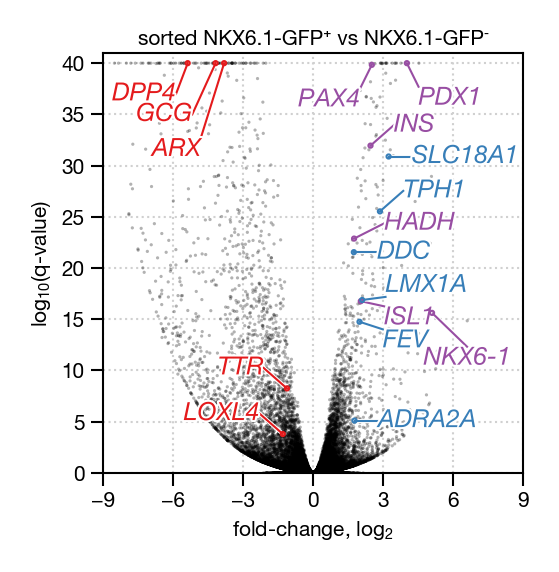

In [20]:
import matplotlib.patheffects as PathEffects
emphasis_color = core_colors.blue
fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.add_axes([0.25, 0.16, 0.70, 0.70],
                  xscale='linear', yscale='linear',
#                   title='Comparison of SC-EC and SC-beta cells'
                  frameon=True)
ax.set_ylabel('log$_{10}$(q-value)', fontsize=5, labelpad=2)
ax.set_xlabel('fold-change, $log_2$', fontsize=5, labelpad=2)
ax.set_title('sorted NKX6.1-GFP⁺ vs NKX6.1-GFP⁻', fontsize=5, pad=2)


# de_genes = (log_fc.abs() > permuted_max_fc) & (log_fc.abs() > np.log2(fc_thr))

x = nkx61_logfc
y = -np.log10(nkx61_pdaj + 10**-40)

# log_fc = np.log2(y) - np.log2(x)
# fc_thr = 4
# de_genes = (log_fc.abs() > np.log2(fc_thr))


ax.scatter(x, y, c='k', s=0.6, edgecolor='none', 
           alpha=0.30,
          rasterized=True)


xlims = [-9, 9]
ylims = [0, 41]
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# ax.set_yticks([-8,-6,-4,-2,0,2,4,6,8])
ax.set_xticks([-9,-6,-3,0,3,6,9])

gene_label_fontsize = 5
# GOOD highlight genes

ec_label_genes = [
    ('FEV', (0.,-0.44), 'left', 'top'),
    ('LMX1A', (0.,0.2), 'left', 'bottom'),
    ('TPH1', (0.,2), 'left', 'center'),
    ('SLC18A1', (0.,.0), 'left', 'center'),
    ('DDC', (0.,.0), 'left', 'center'),
    ('ADRA2A', (0,.0), 'left', 'center',),
#     ('COL5A2', (0,0), 'left', 'bottom',),
]

scb_label_genes = [
    ('PDX1', (-0.5, -2), 'left', 'top'),
    ('ISL1', (0,-0.2), 'left', 'top'),
    ('INS', (0,2), 'left', 'center'),
    ('HADH', (0.3,1.5), 'left', 'center'),
    ('NKX6-1', (1.5,-3), 'center', 'top'),
    ('PAX4', (0.5,-2), 'right', 'top'),
]

ph_label_genes = [
    ('GCG', (0.,-5), 'right', 'center'),
    ('ARX', (0,-7), 'right', 'top'),
    ('DPP4', (0.5,-3), 'right', 'center'),
    ('TTR', (0,2), 'right', 'center'),
    ('LOXL4', (0.,2), 'right', 'center'),
]


ax.grid(True)
ax.yaxis.grid(color='#d0d0d0', linestyle='dotted', linewidth=0.5)
ax.xaxis.grid(color='#d0d0d0', linestyle='dotted', linewidth=0.5)
ax.set_axisbelow(True)
    

for col, label_genes in [(core_colors.purple, scb_label_genes),
                         (core_colors.blue, ec_label_genes),
                         (core_colors.red, ph_label_genes)]:
    
    ax.scatter(x[[g for g,_,_,_ in label_genes]], y[[g for g,_,_,_ in label_genes]], c='none',
           s=1, edgecolor=col,
           alpha=1.0, linewidths = 0.5, zorder=20)
    

    for g,g_offset,ha,va in label_genes:

        x_offset, y_offset = np.array(g_offset)
        if ha =='right':
            x_offset -= 1
        if ha == 'left':
            x_offset += 1
        if va == 'top':
            y_offset += -0.3
        if va == 'bottom':
            y_offset += 0.1
            
            
        xoff = x[g] + x_offset
        yoff = y[g] + y_offset
        
        txt = ax.text(xoff, yoff, g,
                      fontsize=6, color=col,  style='italic',
                      va=va, ha=ha, zorder=15)
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])


        line = ax.plot([x[g], xoff], [y[g], yoff], linewidth=0.5, color=col, zorder=10)
        line[0].set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])

    
        
ax.tick_params(axis='both', which='major', pad=1.5, width=0.5, zorder=-10, length=3)
fig.savefig('../../figures/components/extended_figure5/ExtendedFigure5D.pdf', dpi=600, transparent=True)
